# Data Mining and Exploration [INFR11007]

# Lab 4: Performance evaluation and model selection

In this lab, we look at various performance metrics for classification.  We then turn our attention to cross-validation and hyper-parameter tuning. Finally, we touch on Bayesian optimisation for hyper-parameter tuning.

As always, let's start by importing the basic packages and modules we will need :

In [1]:
from __future__ import division, print_function # Imports from __future__ since we're running Python 2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
random_state = 10 # Ensure reproducible results
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
%matplotlib inline

ImportError: No module named 'sklearn.model_selection'

## Classification performance evaluation
In this lab, we will look at the following classification metrics:
* classification accuracy
* logarithmic loss
* confusion matrices

As always, we will make use of the familiar [landsat satellite](https://archive.ics.uci.edu/ml/datasets/Statlog+%28Landsat+Satellite%29) dataset which is 36-dimensional and comprises 6 classes. 

### Landsat sattelite data pre-processing

### ========== Question 1 ==========
Load the `landsat_train.csv` dataset into a `pandas` DataFrame called  `landsat_train_full`, and the `landsat_test.csv` dataset into a DataFrame called `landsat_test`. Display the shapes of the two DataFrames. 

*Hint: The DataFrames should have 37 columns including the class labels, and 4435 and 2000 entries for the training and testing datasets, respectively.*

In [ ]:
# Your code goes here


### ========== Question 2 ==========
Load the dataset class names stored in `landsat_classes.csv'` into a dictionary. You are free to choose whatever method you wish. 

Replace the label numbers in both the `landsat_train_full` and `landsat_test` DataFrames with the corresponding class names.

*Hint: If unsure, check out the provided solutions for Lab 3.*

In [ ]:
# Your code goes here


### ========== Question 3 ==========
Store the training features, training labels, testing features and testing labels into numpy arrays `X_train_full`, `y_train_full`, `X_test`, and `y_test` respectively.

In [ ]:
# Your code goes here
labels_path = os.path.join(os.getcwd(), 'datasets', 'landsat', 'landsat_classes.csv')
landsat_labels = pd.read_csv(labels_path, delimiter=',', index_col=0)
landsat_labels_dict = landsat_labels.to_dict()["Class"]

def ApplyLabelNames(frameSeries):
    labelValue = frameSeries.loc['label']
    labelName = landsat_labels_dict.get(labelValue)
    return labelName


train_path = os.path.join(os.getcwd(), 'datasets', 'landsat', 'landsat_train.csv')
test_path = os.path.join(os.getcwd(), 'datasets', 'landsat', 'landsat_test.csv')
landsat_train_full = pd.read_csv(train_path, delimiter=',')
landsat_test = pd.read_csv(test_path, delimiter=',')

sLength = len(landsat_train_full['label'])
landsat_train_full['LabelName'] = pd.Series(np.random.randn(sLength), index=landsat_train_full.index)
landsat_train_full['LabelName'] = landsat_train_full.apply(ApplyLabelNames, axis=1)

sLength = len(landsat_test['label'])
landsat_test['LabelName'] = pd.Series(np.random.randn(sLength), index=landsat_test.index)
landsat_test['LabelName'] = landsat_test.apply(ApplyLabelNames, axis=1)





### Hold-out validation
We currently have two datasets, namely `X_train_full` and `X_test`. If we just wanted to train a simple classifier with default settings and evaluate performance on the test subset, then our current approach should be good enough. 

Even simple classifiers, however, have hyper-parameters that need to be carefully tuned. In order to do so, we need a separate validation subset of the data which should be different from the training set. We should never perform model (i.e. hyper-parameter) selection by using the test set, because if we do so, we won't be able to evaluate the generalisation of our model on unseen data (and yes, in case you are wondering, that means that by performing model selection we might in a way *overfit* on the validation set).

The simplest approach we can follow is to split our data three-way, that is, have a training, a validation, and a test set. We are already given the test set, so all we need to do is to split our training set (which we have called `train_full`) into training and validation subsets.

Thankfully, sklearn offers an implementation of this operation which is called [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). By default, this function will shuffle our data before splitting it. The `test_size` input parameter indicates the relative size of the test set (which will be used as the validation set in our case) and the `random_state` parameter can be used to ensure we can get reproducible results if we call this function multiple times.

Let's transform our full training set into two subsets called `train` and `val`. We will feed in our `X_train_full` and `y_train_full` arrays and call the new arrays `X_train`, `X_val`,  `y_train`, and `y_val`, respectively.

In [ ]:
from sklearn.model_selection import train_test_split

xtrainfull = landsat_train_full.iloc[:,0:36].values
print("Shape of xtrainfull is :{0}".format(xtrainfull.shape))
ytrainfull = landsat_train_full['label']
print("Shape of ytrainfull is :{0}".format(ytrainfull.shape))

xtest = landsat_test.iloc[:,0:36].values
print("Shape of xtest is :{0}".format(xtest.shape))
ytest = ytrain = landsat_test['label']
print("Shape of ytest is :{0}".format(ytest.shape))


xtrain, xvalidation, ytrain, yvalidation = train_test_split(xtrainfull, ytrainfull, test_size=0.33, random_state=random_state)


print("Shape of xtrain is :{0}".format(xtrain.shape))
print("Shape of xvalidation is :{0}".format(xvalidation.shape))
print("Shape of ytrain is :{0}".format(ytrain.shape))
print("Shape of yvalidation is :{0}".format(yvalidation.shape))

###  Feature standardisation

We have already seen that [feature standardisation](http://scikit-learn.org/stable/modules/preprocessing.html) (i.e. transforming the data so that they have zero mean and unit variance) is important for some unsupervised dimensionality reduction methods. It turns out that it is also crucial for the training efficiency of many supervised algorithms, especially those that use some form of optimisation (e.g. logistic regression trained via gradient descent). 

Feature standardisation can hardly ever do any harm when it comes to training classifiers, so it is generally good practice to deploy it as a first step in our data processing pipeline.

It is essential, however, to perform feature standardisation by using the training data only. If we use the whole dataset for estimating feature means and variances, we will have information leakage from the test set to the training set, and our results might be over-optimistic.

### ========== Question 4 ==========
Create a [`StandardScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance and fit it by using the training features only (`X_train`). 

Then by using the object you just fit, standardise (i.e. call the `transform()` method) the training, validation and test input features and save the results into three new numpy arrays, `X_train_sc`, `X_val_sc` and `X_test_sc`.

*Hint: If unsure how to perform this step, check out Lab 3.*

In [5]:
# Your code goes here
from sklearn.preprocessing import StandardScaler

standardScalar = StandardScaler()
xTrainStandard = standardScalar.fit_transform(xtrain)
xValidationStandard = standardScalar.fit_transform(xvalidation)
xTestStandard = standardScalar.fit_transform(xtest)



C:\Users\uss2f\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


### Gaussian Naive Bayes classification
Now we want to use a simple Gaussian Naive Bayes classifier to get a feel for the  performance baseline we can achieve on our validation set. Read about the [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) and the underlying assumption if you are not already familiar with it.

We will make use of the `GaussianlNB` class in sklearn. **Check out the user guide [description](http://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes) and [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) to familiarise yourself with this class.**

All classifier objects in sklearn implement a `fit()` and `predict()` method. The first learns the parameters of the model and the latter classifies inputs. For a Naive Bayes classifier, the [`fit()`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB.fit) method takes at least two input arguments `X` and `y`, where `X` are the input features and `y` are the labels associated with each example in the training dataset (i.e. targets). 

Let's train our classifier by calling its `fit()` method:

In [8]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(xTrainStandard,ytrain)

### Classification accuracy

Scikit-learn model objects have built in scoring methods. The default [`score()`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB.score) method for `GaussianNB` estimates classification accuracy. Alternatively, we can compute the prediction for the test data and make use of the [`accuracy_score()`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function (that is in fact what the classifier's `score()` method does under the hood).

In [11]:
gnb_prediction = gnb.predict(xValidationStandard)
gnb_accuracy = accuracy_score(yvalidation, gnb_prediction) # The accuracy_score() function takes as inputs
                                                 # the true labels and the predicted ones

# By using the score() method
gnb_accuracy_alt = gnb.score(xValidationStandard, yvalidation) # The score() method takes as inputs
                                              # the test input features and the associated (true) labels

# Print results
print("GNB classification accuracy on validation set (by using the accuracy_score() function): {:.3f}"
      .format(gnb_accuracy))
print("GNB classification accuracy on validation set (by using the model's score() method): {:.3f}"
      .format(gnb_accuracy_alt))

GNB classification accuracy on validation set (by using the accuracy_score() function): 0.796
GNB classification accuracy on validation set (by using the model's score() method): 0.796


### ========== Question 5 [optional] ==========
Write your own function for computing classification accuracy by taking as inputs the vector of the true labels `y_true` and the vector of predicted labels `y_pred`. Compare its outcome to the results from using the scikit-learn `accuracy_score` metric.

In [ ]:
# Your code goes here


### Baseline classification [optional]

How can we know if the performance of our classifier is vaguely good or bad? One simple idea is to try to compare its performance to baseline.

### ========== Question 6 [optional] ==========

What is the simplest classifier you can think of? (Try for a moment to forget everything you know about machine learning and think how you would classify test inputs in the simplest, and perhaps dumbest, way).

Implement the baseline classifier of your choice and compute its classification accuracy on the validation set. Does the GNB model perform better than the baseline?

This might seem as an unnecessary hassle at this point, but it is important to always check what the baseline performance level is for a given task. There are cases where you can spend hours optimising a classifier, only to find out later on, that its performance does not exceed the baseline (i.e. because the input features, for instance, are not informative of the labels).

In [ ]:
# Your code goes here


### ========== Question 7 [optional] ==========

It turns out that sklearn implements the [`DummyClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) class which offers sever choices for dummy classifiers (`strategy` parameter).  Is the baseline classifier you came up with in the previous question included in this class? If so, double-check that your estimate about baseline performance matches the one returned by the `DummyClassifier` in sklearn.

In [ ]:
from sklearn.dummy import DummyClassifier
# Your code goes here


### Confusion matrix
Scikit-learn also has a [`confusion_matrix`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix) implementation which returns a numpy array (square matrix) of dimensionality `K`, where `K` is the number of classes (`6` in our case).

### ========== Question 8 ========== 
By using the prediction of the Gaussian Naive Bayes model, compute and display the confusion matrix on the validation set.

In [22]:
from sklearn.metrics import confusion_matrix
# Your code goes here
yValidationPrediction = gnb_prediction
confusionMatrixValidation = confusion_matrix(yvalidation,yValidationPrediction)
logLossValidation = log_loss(yvalidation,yValidationPrediction)
plot_confusion_matrix(confusionMatrixValidation)
confusionMatrixValidation


ValueError: y_true and y_pred contain different number of classes 6, 2. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [1 2 3 4 5 7]

You are provided with the following function which uses  `seaborn's` [`heatmap`](http://seaborn.pydata.org/generated/seaborn.heatmap.html) function to visualise a confusion matrix. The parameter `normalize` can be used to  convert the rows of the confusion matrix  into normalised prediction scores/probabilities (i.e. the sum of each row will be equal to 1).

In [14]:
# Plot confusion matrix by using seaborn heatmap function
def plot_confusion_matrix(cm, normalize=False, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix.
    
    If normalize is set to True, the rows of the confusion matrix are normalized so that they sum up to 1.
    
    """
    if normalize is True:
        cm = cm/cm.sum(axis=1)[:, np.newaxis]
        vmin, vmax = 0., 1.
        fmt = '.2f'
    else:
        vmin, vmax = None, None
        fmt = 'd'
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=vmin, vmax=vmax, 
                    annot=True, annot_kws={"fontsize":9}, fmt=fmt)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

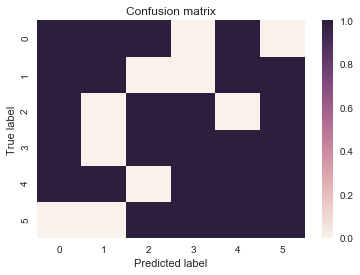

In [15]:
plot_confusion_matrix(c)

### ========== Question 9 ========== 

Use the provided `plot_confusion_matrix` to visualise the confusion matrix on the test dataset. Make two calls of the function, one with the `normalize` parameter set to `True`, and another one with the same parameter set to `False`. Use a single figure with two subplots. Inspect the outcome.

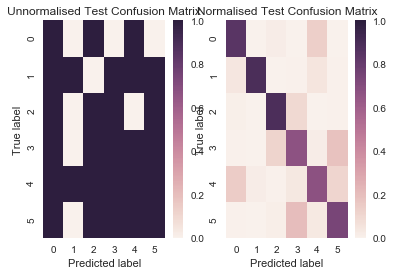

In [19]:
# Your code goes here
yTestPrediction = gnb.predict(xTestStandard)
gnbTestAccuracy = accuracy_score(ytest, yTestPrediction) # The accuracy_score() function takes as inputs
                                                 # the true labels and the predicted ones

# By using the score() method
gnbTestAccuracyScoreMethod = gnb.score(xTestStandard, ytest) # The score() method takes as inputs
                                              # the test input features and the associated (true) labels





confusionMatrixTest = confusion_matrix(ytest,yTestPrediction)

fig, ax = plt.subplots(1,2)
plt.subplot(1,2,1)
plot_confusion_matrix(confusionMatrixTest,normalize=False,title="Unnormalised Test Confusion Matrix")
plt.subplot(1,2,2)
plot_confusion_matrix(confusionMatrixTest,normalize=True,title="Normalised Test Confusion Matrix")
plt.show()

### Cross-entropy (logistic) loss
Classification accuracy is not the only metric used to evaluate classification performance, and in many cases, it can be very misleading. One such case is when we deal with unbalanced datasets in binary classification tasks. In this case, we might want to use different metrics such as [precision](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score), [recall](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score), [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) and/or [area under the ROC curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html). Unfortunately, we won't have time to cover all these in the current lab, but you are free to experiment with them if you are keen.

Another particular case where the accuracy metric is not very useful, is when we care not only about the classification predictions, but also about the associated probability distributions. Sometimes, for instance, we might consider that it is not catastrophic to do a misclassification, as long the associated prediction probability is not too high. In other words, we might want to penalise wrong classifications that are made with high confidence more than misclassifications that are made with low confidence.

One metric that takes into account the prediction probabilities is the [logarithmic loss or cross-entropy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html).  This metric is very often used as the evaluation score in [data science competitions](https://www.kaggle.com/wiki/LogarithmicLoss). You might recognise this metric as the loss funcion used while training logistic regression models and neural networks.

### ========== Question 10 ========== 

By using the [log-loss](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) implementation in sklearn, compute the log-loss scores for the Dummy and Gaussian Naive Bayes classifers from Questions 6 and 8.

In [23]:
from sklearn.metrics import log_loss
# Your code goes here
logLossTest = log_loss(ytest,yTestPrediction)

ValueError: y_true and y_pred contain different number of classes 6, 2. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [1 2 3 4 5 7]

### Classifier comparison
Now we want to compare the performance of different types of classifiers on the validation set. This is a common first step to decide which classifier might be most suitable for the task at hand.

### ========== Question 11 ========== 

Compare the classification accuracy of various types of classifiers of your choice (at least three different types) on the landsat dataset. Use the training set for training classifiers  and the validation set to evaluate performance. 

Log and print the classification accuracy and cross-entropy (aka logarithmic loss) scores for each classifier. 

*Reminder: Make sure you make use of the standardised versions of the data, i.e. `X_train_sc` and `X_val_sc`. *

*Hint:  You might find this `sklearn` [tutorial](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) very useful.*

In [ ]:
# Your code goes here


### ========== Question 12 ========== 

Which classifier seems to perform best on the validation set? 

Are your observations as expected, or do you find them rather suprising? 

Would you trust the results of this  comparison?  If not, explain why.

*Your answer goes here*



## Hyper-parameter tuning

If we want to optimise the hyper-parameters of classifiers we should never do so by using the test set. If we compare the performance of various classifiers -after we have tuned their hyper-parameters- by using a validation set, we should equally not use the same  set for parameter optimisation. 

Instead, we should use two independent procedures for hyper-parameter tuning and classifier comparison. For instance, we could split again our training set into two subsets and use the former to train classifiers under various parameter configurations and the latter to assess performance. Then by picking the parameter settings which gave optimal results for each classifier, we can compare the performance of the best-performing models on our original validation set. 

Alternatively, we can use [K-fold cross-validation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) on the training set for setting hyper-parameters; this approach will yield slightly more reliable results, since hyper-parameter selection will be based on averaging across a few runs. 

Sklearn offers a very convenient tool for fitting model hyperparameters called [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Spend a few minutes reading the documentation of this class and make sure you understand how it works.

A `GridSearchCV` classifier is constructed by defining the following parameters, among others:
* `estimator`: this is another (base) classifier which has been constructed but not fitted yet.
* `param_grid`: this is a dictionary, where the different hyper-parameters to be optimised are defined, as well as the search space for each hyper-parameter, which can be either discrete or continuous.
* `scoring`: this is a string defining the objective function (i.e. scoring method) to be used for hyper-parameter optimisation. Some options are `accuracy` for classification accuracy, `neg_log_loss` for log-loss, or user-defined metrics. A list of all the available metrics can be found [here](http://scikit-learn.org/stable/modules/model_evaluation.html).
* `cv`: cross-validation to be used for optimising the hyper-parameters. This can be either an integer `K` or a sklearn cross-validation generator. If an integer is provided, then `KFold` cross-validation will be used. By default sklearn will use 3-fold CV.

Let's now make a first attempt to optimise the regularisation parameter `C` of an [`SVM`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) classifier with an RBF kernel. 

Spend a few moments to understand what the following piece of code does. You can hopefully  see that after we have fitted a `GridSearchCV` classifier, we can access the best scores achieved and best-scoring parameter configurations by looking at the `best_params_` and `best_score_` attributes, respectively.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

cv = KFold(n_splits=3, shuffle=True, random_state=random_state)
svc = SVC(kernel='rbf')
parameters = {'C': np.logspace(-3,3,7)}
svc_clf = GridSearchCV(estimator=svc, cv=cv, param_grid=parameters, scoring='accuracy')
svc_clf.fit(X_train_sc, y_train)
print("Best setting of C parameter for SVC with RBF kernel: {}".format(svc_clf.best_params_["C"]))
print("Best cross-validated score: {:.3f}".
      format(svc_clf.best_score_))
print("Classification accuracy on validation set: {:.3f}".format(svc_clf.score(X_val_sc,y_val)))

### ========== Question 13 ========== 

By adapting the above code provided, optimise both the regularisation parameter `C` and the kernel coefficient `gamma` of an SVM classifier with RBF kernel. 

For `C`, you can use the previous grid, and for `gamma` you can use a logarithmic range between $10^{-4}$ to $10^{1}$.

Print the best scoring parameter configuration and the classification accuracy score on the validation set.

In [ ]:
# Your code goes here


### ========== Question 14 ========== 

How does the performance on the validation set compare to that achieved previously with other classifers? 

If you did not want to use the provided `GridSearchCV` and `KFold` modules from sklearn but wanted to write your own code from scratch, how many *for-loops* would you have included in your code?

*Your answer goes here*



### ========== Question 15 [Optional] ========== 

Optimise the number of hidden units and regularisation constant `alpha` of an [MLP classifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) with one hidden layer. Use the `neg_log_loss` as the scoring function, which will perform hyper-parameter optimisation by minimising the log-loss (i.e. cross-entropy). Use default settings for the other parameters.

In [ ]:
# Your code goes here



### ========== Question 16 [Optional] ========== 

Why is the classification accuracy not better than the one achieved in Question 11? Did we do something wrong?

*Your answer goes here*


## Bayesian optimisation

Bayesian optimisation is a strategy for optimising black-box functions without the need for computing derivatives. Bayesian optimisation methods can prove very useful for optimising the hyper-parameters of machine learning models in arbitrary search spaces, for both continuous and discrete-valued hyper-parameters.

In this final section, we will use the [`scikit-optimize`](https://scikit-optimize.github.io) package to tune the `C` and `gamma` hyper-parameters of an SVM classifier with RBF kernel (see Question 13). We will use a Gaussian Process prior over the average cross-validated classification accuracy score, and will try to maximise this metric by tuning the SVM hyper-parameters. 

Spend a few moments trying to understand what the following piece of code does. If something is not clear, you can consult the skopt [documentation and examples](https://scikit-optimize.github.io).

In [ ]:
from sklearn.model_selection import cross_val_score
cv = KFold(n_splits=3, shuffle=True, random_state=random_state) # We want to use 3-fold CV to compute the loss in each iteration
svc_clf = SVC(kernel='rbf') # Constructor without defining hyper-parameters just yet

def objective_svc(params): # Here we define the metric we want to minimise
    C, gamma = params
    svc_clf.set_params(C=C, 
                      gamma=gamma) # Set the parameters of the clf
    
    return -np.mean(cross_val_score(svc_clf, X_train_sc, y_train, cv=cv, n_jobs=-1,
                                    scoring="accuracy")) # We want to maximise average accuracy, i.e. minimise minus average accuracy

# Search space for the two parameters
space  = [(10**-3, 10**3, "uniform"), # C
          (10**-4, 10**1, "uniform")] # gamma

# Initial values (optional)
x0 = [1, 10**-2]

The following piece of code uses the above defined cost function (`objective_scv`) and the skopt `gp_minimise` function to select the best hyper-parameter configuration in the defined search space. The input parameters are as follows:
* `func`: function that we wish to minimise
* `dimensions`: the search space for the hyper-parameters
* `x0`: inital values for the hyper-parameters
* `n_calls`: number of times the function will be evaluated
* `random_state`: random seed
* `n_random_starts`: before we start modelling the optimised function with a GP Regression model, we want to try a few random choices for the hyper-parameters.
* `kappa`: trade-off between [exploration vs. exploitation](https://en.wikipedia.org/wiki/Multi-armed_bandit).

In [ ]:
from skopt import gp_minimize
res_gp = gp_minimize(func=objective_svc, dimensions=space, x0=x0, 
                     n_calls=25, random_state=random_state, n_random_starts=5, kappa=1.9)
print("Best score with Bayesian optimisation: {:.3f}".format(-res_gp.fun))
print("Best parameters with Bayesian optimisation:\nC: {}\ngamma: {}"
      .format(res_gp.x[0],res_gp.x[1]))

By using the skopt `plot_convergence` function, we can plot the objective function (i.e. evaluated cross-validated accuracy score) against the number of iterations of the Bayesian optimisation process.

In [ ]:
from skopt.plots import plot_convergence
plt.figure(figsize=(5,2))
plot_convergence(res_gp)
plt.grid()
plt.show()

It is important to clarify here, that the plot above shows the minimum value of the optimised function achieved at step $n$. Nevertheless, this does not mean that at a certain step the objective function should always decrease as compared to the previous step (as is the case with e.g. with gradient descent). 

If we wish to plot the value of the evaluated function $f \left (x \right)$ vs. the iteration number $n$, we can do the following:

In [ ]:
plt.figure(figsize=(5,2))
plt.plot(res_gp.func_vals)
plt.scatter(range(len(res_gp.func_vals)), res_gp.func_vals)
plt.ylabel(r'$f(x)$')
plt.xlabel('Number of calls $n$')
plt.xlim([0, len(res_gp.func_vals)])
plt.show()

Now, let's compute the classification accuracy on the validation set by using the selected hyper-parameter configuration. Since we are not performing any further comparisons or hyper-parameter optimisation, we can finally use the test set to report the performance of our selected method.

In [ ]:
svc_opt = SVC(kernel='rbf',
             C=res_gp.x[0],
             gamma=res_gp.x[1]).fit(X_train_sc,y_train)
print("Classification accuracy on validation set: {:.3f}".format(accuracy_score(y_val, svc_opt.predict(X_val_sc))))
print("Classification accuracy on test set: {:.3f}".format(accuracy_score(y_test, svc_opt.predict(X_test_sc))))

Let's take a moment to reflect on what we have achieved here. By running only 25 function evaluations (i.e. iterations), we have achieved 0.916 accuracy on the validation set. This is only 0.1%  smaller than the best score achieved with grid search optimisation, where we had to evaluate our cost function 42 times (since we used a 7 X 6 grid). If we allow the GP optimiser to run for more iterations, we might even get higher performance than we can achieve with grid-search, since we are not restricting our hyper-parameters to discrete values, as opposed to grid search optimisation.

Finally, it is worth noting that the classification performance scores are slightly different for the validation and test sets. In this part we have not used the validation set to perform hyper-parameter optimisation (remember we used K-fold CV within the training set to do so), hence, we can view `y_val` and `y_test` two as two separate test sets. The computed classification accuracy scores are only approximations of the performance of the classifier on unseen data. The observed difference in performance for the two sets is due to the fluctuation of the approximation when using finite size datasets.

### ========== Question 17 [Optional] ========== 

Use the skopt package to tune the hyper-parameters of an [MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) with one hidden layer (i.e. number of hidden units and `alpha`) via Bayesian optimisation. 

Finally, report the accuracy of the best parameter configuration on the validation and test sets.

In [ ]:
# Your code goes here
